In [1]:
import xarray as xr
import pandas as pd
import computeIndicator as CI
import numpy as np

In [2]:
ModelTas=xr.open_dataset("../Data/data_pynar/tasAdjust_France_MPI-M-MPI-ESM-LR_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_MF-ADAMONT-SAFRAN-1980-2011_day_19500101-20051231.nc")

In [3]:
dataTemp=ModelTas.sel(time=slice('2002','2005'))
dataTemp['tasAdjust']=dataTemp.tasAdjust-273.15 
dataTemp

<xarray.Dataset>
Dimensions:         (x: 143, y: 134, time: 1461)
Coordinates:
  * x               (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.188e+06 1.196e+06
  * y               (y) float64 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06
  * time            (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2005-12-31
    lat             (y, x) float64 ...
    lon             (y, x) float64 ...
Data variables:
    LambertParisII  float64 ...
    tasAdjust       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/40)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    comment:                        CORDEX Europe RCM CCLM 0.11 deg EUR-11
    ...                             ...
    bc_period_ref:                  1980-2011
    bc_period_rcm:                  1974-2005
    bc_info:                        Meteo-France-ADAMONT-France_SAFRAN-France...
    product:                        bias-correction
    bc_comment:                     Weather Regime dependant BC methode
    Conventions:                    CF-1.6

In [4]:
s4 = xr.Dataset(
    data_vars={
        "stage": (["time", "y", "x"], np.full((4, dataTemp.y.size, dataTemp.x.size), np.random.randint(5, 26)))
    },
    coords={
        "time": pd.date_range(start="2002", end="2006", freq="YE"),
        "y": dataTemp.y,
        "x": dataTemp.x
    }
)
s5 = xr.Dataset(
    data_vars={
        "stage": (["time", "y", "x"], np.full((4, dataTemp.y.size, dataTemp.x.size), np.random.randint(100, 130)))
    },
    coords={
        "time": pd.date_range(start="2002", end="2006", freq="YE"),
        "y": dataTemp.y,
        "x": dataTemp.x
    }
)

In [5]:
# Convertir les coordonnées time en années (integer) pour s4 et s5
s4['time'] = s4.time.dt.year
s5['time'] = s5.time.dt.year


In [5]:
s4

<xarray.Dataset>
Dimensions:  (time: 4, y: 134, x: 143)
Coordinates:
  * time     (time) datetime64[ns] 2002-12-31 2003-12-31 2004-12-31 2005-12-31
  * y        (y) float64 1.617e+06 1.625e+06 1.633e+06 ... 2.673e+06 2.681e+06
  * x        (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.18e+06 1.188e+06 1.196e+06
Data variables:
    stage    (time, y, x) int64 14 14 14 14 14 14 14 14 ... 14 14 14 14 14 14 14

In [6]:
test=CI.compute_indicator_netcdf(climate_data=dataTemp,NameIndicator="hdaystmean",threshold=20,varName="tasAdjust",two_years_culture=True,start_stage=s4,end_stage=s5)

2002
2003


UnboundLocalError: cannot access local variable 'rast_start' where it is not associated with a value

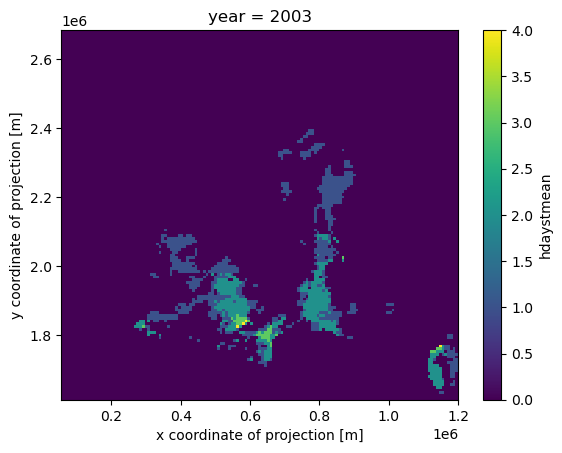

In [10]:
test.isel(year=1).hdaystmean.plot()

In [8]:
climate_data=dataTemp
NameIndicator="meant"
threshold=20
varName="tasAdjust"
two_years_culture=True
start_stage=s4
end_stage=s5

In [9]:
classMoy = ["mint", "maxt", "meant", "avsorad"]
classDaySup = ["hdaystmax", "hdaystmin", "hdaystmean", "excraidays"]
classSum = ["rainsum", "sumetp"]
classDayInf = ["cdaystmin", "defraidays"]
classFreqSup = ["raifreq", "excraifreq", "hsfreq"]
classFreqInf = ["cfreqtmean", "cfreqtmin"]

import xarray as xr
import pandas as pd
import numpy as np

# Get time information
time = climate_data.time

doy = pd.DatetimeIndex(time.values).dayofyear

years = pd.DatetimeIndex(time.values).year.unique()

# Process each year
results = []
for year in years:
    print(year)
    
    if two_years_culture:
        # Select current and previous year
        mask = ((time.dt.year == year) | (time.dt.year == year-1))
        rast_year = climate_data.sel(time=mask)
        
        if len(rast_year.time) < 367:
            result = xr.full_like(climate_data[varName].isel(time=0), np.nan)
            result = result.drop("time")
            result = result.assign_coords(year=year)
            results.append(result)
            continue
            
    else:
        # Select only current year
        rast_year = climate_data.sel(time=time.dt.year==year)
        if len(rast_year.time) < 367:
            result = xr.full_like(climate_data[varName].isel(time=0), np.nan)
            result = result.drop("time")
            results.append(result)
            continue
        
    if isinstance(start_stage, xr.Dataset):
        rast_start = start_stage.sel(time=year)
        rast_start = rast_start.stage
    if isinstance(end_stage, xr.Dataset):
        rast_end = end_stage.sel(time=year)
        rast_end = rast_end.stage
    
    # Apply calculation
    if NameIndicator in classMoy:
        result = xr.apply_ufunc(
            lambda x, start, end: np.mean(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)]),
            rast_year[varName],
            rast_start,
            rast_end,
            input_core_dims=[['time'], [], []],
            vectorize=True)
        result = result.assign_coords(year=year)

    elif NameIndicator in classDaySup:
        result = xr.apply_ufunc(
            lambda x, start, end: np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)] > threshold),
            rast_year[varName],
            rast_start,
            rast_end,
            input_core_dims=[['time'], [], []],
            vectorize=True)
        
    elif NameIndicator in classSum:
        result = xr.apply_ufunc(
            lambda x, start, end: np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)]),
            rast_year[varName],
            rast_start,
            rast_end,
            input_core_dims=[['time'], [], []],
            vectorize=True)
        
    elif NameIndicator in classDayInf:
        result = xr.apply_ufunc(
            lambda x, start, end: np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)] < threshold),
            rast_year[varName],
            rast_start,
            rast_end,
            input_core_dims=[['time'], [], []],
            vectorize=True)
        
    elif NameIndicator in classFreqSup:
        result = xr.apply_ufunc(
            lambda x, start, end: (np.sum(x[(np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)] > threshold) * 100) / np.sum((np.arange(len(x)) >= start-1) & (np.arange(len(x)) <= end-1)),
            rast_year[varName],
            rast_start,
            rast_end,
            input_core_dims=[['time'], [], []],
            vectorize=True)
        
    results.append(result)

2002
2003
2004
2005


In [10]:
results

[<xarray.DataArray 'tasAdjust' (y: 134, x: 143)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * x        (x) float64 6e+04 6.8e+04 7.6e+04 ... 1.18e+06 1.188e+06 1.196e+06
   * y        (y) float64 1.617e+06 1.625e+06 1.633e+06 ... 2.673e+06 2.681e+06
     lat      (y, x) float64 ...
     lon      (y, x) float64 ...
     year     int64 2002,
 <xarray.DataArray (y: 134, x: 143)>
 array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
        [     nan,      nan,      nan, ..., 9.976256,      nan,      nan],
        [     nan,      nan,      nan, ..., 9.827726,      nan,      nan],
        ...,
        [     nan,      nan,      nan, ...,      nan,      nan,      nan],
        [     nan,      nan,      n

In [173]:
if results:
    output = xr.concat(results, dim="year").to_dataset()
    output = output.rename({varName: NameIndicator})
    #return output
else:
    xr.Dataset()
